In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Analyses
from src.analyses.schedule_jobs_dataframe import jobs_metrics_from_operations_df, mean_start_deviation_per_shift_df

# Plots
from src.analyses.fig_experiment import make_combined_figure_startdeviation_tardiness_earliness

## Import and Merge

### I. Experiment Parameters

In [2]:
df_experiments = pd.read_csv("experiments_v01.csv")
df_experiments

,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,max_utilization
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,0.75
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,0.75
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,0.75
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,0.75
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,0.75
...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,0.95
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,0.95
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,0.95
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,0.95


### II. Kendall Tau

In [4]:
from src.utils.analysis.DataFrameEvaluation import get_kendall_tau_experiment_shift_df

df_schedules = pd.read_csv("schedules_v01.csv")

df_kendall = get_kendall_tau_experiment_shift_df(
    df_schedules
)
df_kendall

,Experiment_ID,Shift,Kendall_Tau
0,B-1,2,0.733333
1,B-1,3,0.893334
2,B-1,4,0.806854
3,B-1,5,0.973989
4,B-1,6,1.000000
...,...,...,...
3775,R-99,18,0.992857
3776,R-99,19,0.887231
3777,R-99,20,0.963333
3778,R-99,21,0.837396


In [5]:
df_kendall_mean = (
    df_kendall
    .groupby("Experiment_ID", dropna=False)["Kendall_Tau"]
    .mean()
    .reset_index()
    .rename(columns={"Kendall_Tau": "Mean_Kendall_Tau"})
)

# 2️⃣ Mit df_experimente zusammenführen
df_experiments = df_experiments.merge(df_kendall_mean, on="Experiment_ID", how="left")
df_experiments

,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,max_utilization,Mean_Kendall_Tau
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,0.75,0.915091
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,0.75,0.987228
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,0.75,0.971791
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,0.75,0.990386
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,0.75,0.977324
...,...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,0.95,0.738511
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,0.95,0.771098
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,0.95,0.762085
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,0.95,0.728353


### III. Lateness Metrics

In [6]:
df_metrics = jobs_metrics_from_operations_df(df_schedules)

df_mean_metrics = (
    df_metrics
    .groupby("Experiment_ID")[["Tardiness", "Earliness"]]
    .mean()
    .round(2)  # ➜ Rundet auf 2 Nachkommastellen
    .reset_index()
    .rename(columns={
        "Tardiness": "Mean_Tardiness",
        "Earliness": "Mean_Earliness"
    })
)

# Mit df_experiments zusammenführen
df_experiments = df_experiments.merge(df_mean_metrics, on="Experiment_ID", how="left")
df_experiments

,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,max_utilization,Mean_Kendall_Tau,Mean_Tardiness,Mean_Earliness
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,0.75,0.915091,1.26,278.33
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,0.75,0.987228,3.31,1.61
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,0.75,0.971791,3.89,0.70
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,0.75,0.990386,4.72,0.00
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,0.75,0.977324,284.67,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,0.95,0.738511,25.88,352.34
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,0.95,0.771098,48.71,2.70
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,0.95,0.762085,51.49,1.11
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,0.95,0.728353,38.69,0.06


### IV. Deviation

In [8]:
df_shift_dev = pd.read_csv("experiment_shift_dev_v01.csv")


df_dev_mean = (
    df_shift_dev
    .groupby("Experiment_ID")["Deviation",]
    .mean()
    .round(2)  # ➜ Rundet auf 2 Nachkommastellen
    .reset_index()
    .rename(columns={"Deviation": "Mean_Deviation", "Pairs": "Mean_Pairs"})
)
df_experiments = df_experiments.merge(df_dev_mean, on="Experiment_ID", how="left")
df_experiments

,Experiment_ID,Abs Lateness Ratio,Inner Tardiness Ratio,Max Bottleneck Utilization,Sim Sigma,Shift Length,w_t,w_e,w_dev,Experiment_Type,max_utilization,Mean_Kendall_Tau,Mean_Tardiness,Mean_Earliness,Mean_Deviation
0,B-1,0.25,1.00,0.75,0.1,1440,1,0,3,CP,0.75,0.915091,1.26,278.33,38.38
1,B-2,0.25,0.75,0.75,0.1,1440,3,1,12,CP,0.75,0.987228,3.31,1.61,10.02
2,B-3,0.25,0.50,0.75,0.1,1440,1,1,6,CP,0.75,0.971791,3.89,0.70,11.01
3,B-4,0.25,0.25,0.75,0.1,1440,1,3,12,CP,0.75,0.990386,4.72,0.00,10.98
4,B-5,0.25,0.00,0.75,0.1,1440,0,1,3,CP,0.75,0.977324,284.67,0.00,16.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,R-125,1.00,1.00,0.95,0.3,1440,1,0,0,CP,0.95,0.738511,25.88,352.34,223.00
176,R-126,1.00,0.75,0.95,0.3,1440,3,1,0,CP,0.95,0.771098,48.71,2.70,189.03
177,R-127,1.00,0.50,0.95,0.3,1440,1,1,0,CP,0.95,0.762085,51.49,1.11,199.76
178,R-128,1.00,0.25,0.95,0.3,1440,1,3,0,CP,0.95,0.728353,38.69,0.06,203.35


## Evaluate

In [9]:
from typing import Optional, Tuple, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize

ExtendType = Literal["auto", "both", "min", "max", None]

def plot_experiment_heatmaps(
    df: pd.DataFrame,
    *,
    value_col: str,
    x_col: str,
    y_col: str,
    col_col: str,
    row_col: str,
    cmap_name: str = "RdYlGn",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    annot: bool = False,
    fmt: str = ".2f",
    text_color: str = "black",
    figsize_scale: Tuple[float, float] = (4.8, 4.2),
    legend_steps: int = 6,
    # Steuerung der „Gut/Schlecht“-Richtung:
    higher_is_better: bool = True,
    auto_reverse_cmap: bool = True,
    # Colorbar-Steuerung:
    extend: ExtendType = "auto",  # "auto" | "both" | "min" | "max" | None
    colorbar_fraction: float = 0.04,
    colorbar_pad: float = 0.02,
    # Titel:
    title: Optional[str] = None,
):
    # 1) Facetten-Keys
    unique_cols = sorted(df[col_col].unique())
    unique_rows = sorted(df[row_col].unique())
    n_cols, n_rows = len(unique_cols), len(unique_rows)

    # 2) Wertebereich
    z_all = df[value_col].to_numpy(dtype=float)
    data_min, data_max = float(np.nanmin(z_all)), float(np.nanmax(z_all))
    if vmin is None: vmin = data_min
    if vmax is None: vmax = data_max
    if vmin > vmax:
        raise ValueError("vmin darf nicht größer als vmax sein.")

    # 3) Colormap + ggf. Richtungsumkehr
    base_cmap = mpl.colormaps.get_cmap(cmap_name)
    cmap = base_cmap
    reversed_cmap = False
    if auto_reverse_cmap:
        # Ziel: Bei „niedrig = gut“ invertieren wir die Farbrichtung.
        ends_with_r = cmap_name.endswith("_r")
        want_reversed = not higher_is_better
        if want_reversed ^ ends_with_r:  # XOR → invertieren, wenn nötig
            cmap = base_cmap.reversed()
            reversed_cmap = True

    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

    # 4) Diskrete Stufen (stabile Sortierung)
    x_levels = list(np.sort(df[x_col].unique()))
    y_levels = list(np.sort(df[y_col].unique()))

    # 5) Figure/Axes
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize_scale[0]*n_cols, figsize_scale[1]*n_rows),
        constrained_layout=True, sharex=True, sharey=True
    )
    axes = np.atleast_2d(axes)

    for i, r in enumerate(unique_rows):
        for j, c in enumerate(unique_cols):
            ax = axes[i, j]
            sub = df[(df[row_col] == r) & (df[col_col] == c)]
            if sub.empty:
                ax.set_visible(False)
                continue

            # Pivot: Zeilen = y, Spalten = x
            pivot = (
                sub.pivot_table(index=y_col, columns=x_col, values=value_col, aggfunc="mean")
                  .reindex(index=y_levels, columns=x_levels)
            )
            ny, nx = pivot.shape

            # pcolormesh-Gitter
            X, Y = np.meshgrid(np.arange(nx+1), np.arange(ny+1))
            ax.pcolormesh(
                X, Y, pivot.values,
                cmap=cmap, norm=norm,
                shading="flat", edgecolors="none"
            )

            # Ticks in Zellmitten
            ax.set_xticks(np.arange(nx) + 0.5)
            ax.set_yticks(np.arange(ny) + 0.5)
            ax.set_xticklabels([str(x) for x in x_levels])
            ax.set_yticklabels([str(y) for y in y_levels])

            if i == 0:
                ax.set_title(f"{col_col} = {c}")
            if j == 0:
                ax.set_ylabel(f"{row_col} = {r}\n{y_col}")
            ax.set_xlabel(x_col)

            # Optional: Annot
            if annot:
                vals = pivot.values
                for yi in range(ny):
                    for xi in range(nx):
                        v = vals[yi, xi]
                        if np.isfinite(v):
                            ax.text(xi+0.5, yi+0.5, format(v, fmt),
                                    ha="center", va="center", color=text_color)

    # 6) Colorbar + extend
    # Automatik nur, wenn extend="auto"
    if extend == "auto":
        _extend = None
        if data_min < vmin and data_max > vmax:
            _extend = "both"
        elif data_min < vmin:
            _extend = "min"
        elif data_max > vmax:
            _extend = "max"
    else:
        _extend = extend  # direkt übernehmen ("both" | "min" | "max" | None)

    # Keine Umschaltung des extend bei invertierter Colormap!
    # extend bezieht sich auf Wertebereiche, nicht auf Farb- oder Anzeigerichtung.

    # Colorbar zeichnen
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=axes.ravel().tolist(),
        orientation="vertical",
        fraction=colorbar_fraction,
        pad=colorbar_pad,
        label=value_col,
        extend=_extend,
    )

    # Ticks und Labels
    ticks = np.linspace(vmin, vmax, legend_steps)
    cbar.set_ticks(ticks)
    cbar.ax.set_yticklabels([f"{t:.2f}" for t in ticks])


    # 7) Titel
    if title is None:
        better_txt = "höhere Werte = besser" if higher_is_better else "niedrigere Werte = besser"
        title = f"Heatmap ({value_col}): je {col_col} × {row_col} – {better_txt}"
    fig.suptitle(title, fontsize=13)

    return fig, axes


# --------------------------
# Wrapper 1: hoch = gut (z. B. Kendall Tau, Accuracy, AUC)
# --------------------------
def plot_experiment_heatmaps_good_high(
    df: pd.DataFrame,
    *,
    value_col: str,
    x_col: str,
    y_col: str,
    col_col: str,
    row_col: str,
    cmap_name: str = "RdYlGn",
    **kwargs
):
    return plot_experiment_heatmaps(
        df,
        value_col=value_col,
        x_col=x_col, y_col=y_col,
        col_col=col_col, row_col=row_col,
        cmap_name=cmap_name,
        higher_is_better=True,
        auto_reverse_cmap=True,
        **kwargs
    )


# --------------------------
# Wrapper 2: niedrig = gut (z. B. Tardiness, Loss, Error)
# --------------------------
def plot_experiment_heatmaps_good_low(
    df: pd.DataFrame,
    *,
    value_col: str,
    x_col: str,
    y_col: str,
    col_col: str,
    row_col: str,
    cmap_name: str = "RdYlGn",
    **kwargs
):
    # gleiche Basis-Cmap wie oben; Richtung wird automatisch invertiert
    return plot_experiment_heatmaps(
        df,
        value_col=value_col,
        x_col=x_col, y_col=y_col,
        col_col=col_col, row_col=row_col,
        cmap_name=cmap_name,
        higher_is_better=False,
        auto_reverse_cmap=True,
        **kwargs
    )


In [19]:
from typing import Optional, Tuple, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize

ExtendType = Literal["auto", "both", "min", "max", None]

def plot_experiment_heatmaps(
    df: pd.DataFrame,
    *,
    value_col: str,
    x_col: str,
    y_col: str,
    col_col: Optional[str] = None,   # jetzt optional
    row_col: Optional[str] = None,   # jetzt optional
    cmap_name: str = "RdYlGn",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    annot: bool = False,
    fmt: str = ".2f",
    text_color: str = "black",
    figsize_scale: Tuple[float, float] = (4.8, 4.2),
    legend_steps: int = 6,
    # Gut/Schlecht-Richtung:
    higher_is_better: bool = True,
    auto_reverse_cmap: bool = True,
    # Colorbar:
    extend: ExtendType = "auto",
    colorbar_fraction: float = 0.04,
    colorbar_pad: float = 0.02,
    # Titel:
    title: Optional[str] = None,
):
    # 1) Facetten-Keys (optional)
    if col_col is None:
        unique_cols = [None]
    else:
        unique_cols = sorted(df[col_col].unique())

    if row_col is None:
        unique_rows = [None]
    else:
        unique_rows = sorted(df[row_col].unique())

    n_cols, n_rows = len(unique_cols), len(unique_rows)

    # 2) Wertebereich
    z_all = df[value_col].to_numpy(dtype=float)
    data_min, data_max = float(np.nanmin(z_all)), float(np.nanmax(z_all))
    if vmin is None: vmin = data_min
    if vmax is None: vmax = data_max
    if vmin > vmax:
        raise ValueError("vmin darf nicht größer als vmax sein.")

    # 3) Colormap + ggf. Richtungsumkehr
    base_cmap = mpl.colormaps.get_cmap(cmap_name)
    cmap = base_cmap
    if auto_reverse_cmap:
        ends_with_r = cmap_name.endswith("_r")
        want_reversed = not higher_is_better
        if want_reversed ^ ends_with_r:
            cmap = base_cmap.reversed()

    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

    # 4) Diskrete Stufen (stabile Sortierung)
    x_levels = list(np.sort(df[x_col].unique()))
    y_levels = list(np.sort(df[y_col].unique()))

    # 5) Figure/Axes
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize_scale[0]*n_cols, figsize_scale[1]*n_rows),
        constrained_layout=True, sharex=True, sharey=True
    )
    axes = np.atleast_2d(axes)

    for i, r in enumerate(unique_rows):
        for j, c in enumerate(unique_cols):
            ax = axes[i, j]

            # Subset filtern abhängig von optionalen Facetten
            sub = df.copy()
            if row_col is not None:
                sub = sub[sub[row_col] == r]
            if col_col is not None:
                sub = sub[sub[col_col] == c]

            if sub.empty:
                ax.set_visible(False)
                continue

            # Pivot: Zeilen = y, Spalten = x
            pivot = (
                sub.pivot_table(index=y_col, columns=x_col, values=value_col, aggfunc="mean")
                  .reindex(index=y_levels, columns=x_levels)
            )
            ny, nx = pivot.shape

            # pcolormesh-Gitter
            X, Y = np.meshgrid(np.arange(nx+1), np.arange(ny+1))
            ax.pcolormesh(
                X, Y, pivot.values,
                cmap=cmap, norm=norm,
                shading="flat", edgecolors="none"
            )

            # Ticks in Zellmitten
            ax.set_xticks(np.arange(nx) + 0.5)
            ax.set_yticks(np.arange(ny) + 0.5)
            ax.set_xticklabels([str(x) for x in x_levels])
            ax.set_yticklabels([str(y) for y in y_levels])

            # Titel oben pro Spalte (nur wenn col_col existiert)
            if i == 0:
                if col_col is not None:
                    ax.set_title(f"{col_col} = {c}")
                elif title is None and n_cols == 1 and n_rows == 1:
                    # kein col_col/row_col → Einzel-Plot: kleiner Titel pro Ax lassen wir leer
                    pass

            # Y-Label links (nur wenn row_col existiert)
            if j == 0:
                if row_col is not None:
                    ax.set_ylabel(f"{row_col} = {r}\n{y_col}")
                else:
                    ax.set_ylabel(y_col)

            ax.set_xlabel(x_col)

            # Optional: Annot
            if annot:
                vals = pivot.values
                for yi in range(ny):
                    for xi in range(nx):
                        v = vals[yi, xi]
                        if np.isfinite(v):
                            ax.text(xi+0.5, yi+0.5, format(v, fmt),
                                    ha="center", va="center", color=text_color)

    # 6) Colorbar + extend (ohne Spiegeln)
    if extend == "auto":
        _extend = None
        if data_min < vmin and data_max > vmax:
            _extend = "both"
        elif data_min < vmin:
            _extend = "min"
        elif data_max > vmax:
            _extend = "max"
    else:
        _extend = extend  # "both" | "min" | "max" | None

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(
        sm,
        ax=axes.ravel().tolist(),
        orientation="vertical",
        fraction=colorbar_fraction,
        pad=colorbar_pad,
        label=value_col,
        extend=_extend,
    )

    # Ticks und Labels
    ticks = np.linspace(vmin, vmax, legend_steps)
    cbar.set_ticks(ticks)
    cbar.ax.set_yticklabels([f"{t:.2f}" for t in ticks])

    return fig, axes


# Wrapper: hoch = gut (z. B. Tau, Accuracy, AUC)
def plot_experiment_heatmaps_good_high(
    df: pd.DataFrame,
    *,
    value_col: str,
    x_col: str,
    y_col: str,
    col_col: Optional[str] = None,
    row_col: Optional[str] = None,
    cmap_name: str = "RdYlGn",
    **kwargs
):
    return plot_experiment_heatmaps(
        df,
        value_col=value_col,
        x_col=x_col, y_col=y_col,
        col_col=col_col, row_col=row_col,
        cmap_name=cmap_name,
        higher_is_better=True,
        auto_reverse_cmap=True,
        **kwargs
    )

def plot_experiment_heatmaps_kendall_tau(
    df: pd.DataFrame,
    value_col: str,
    x_col: str = "Inner Tardiness Ratio", x_col_as: Optional[str]= None,
    y_col: str = "Inner Tardiness Ratio", y_col_as: Optional[str]= None,
    col_col: Optional[str] = None, col_col_as: Optional[str] = None,
    row_col: Optional[str] = None, row_col_as: Optional[str] = None,
    vmin: Optional[float] = 0.7,
    fmt: str = ".2f",
    extend: ExtendType = "both",
):
    return plot_experiment_heatmaps(
        df,
        value_col=value_col,
        x_col=x_col, y_col=y_col,
        col_col=col_col, row_col=row_col,
        vmin=vmin,
        fmt = fmt,
        extend=extend,
        annot=True,
        cmap_name="RdYlGn",
        higher_is_better=True,
        auto_reverse_cmap=True,
        vmax=1.0,
    )


# Wrapper: niedrig = gut (z. B. Tardiness, Loss, Error)
def plot_experiment_heatmaps_good_low(
    df: pd.DataFrame,
    value_col: str,
    x_col: str,
    y_col: str,
    col_col: Optional[str] = None,
    row_col: Optional[str] = None,
    cmap_name: str = "RdYlGn",
    **kwargs
):
    return plot_experiment_heatmaps(
        df,
        value_col=value_col,
        x_col=x_col, y_col=y_col,
        col_col=col_col, row_col=row_col,
        cmap_name=cmap_name,
        higher_is_better=False,
        auto_reverse_cmap=True,
        **kwargs
    )


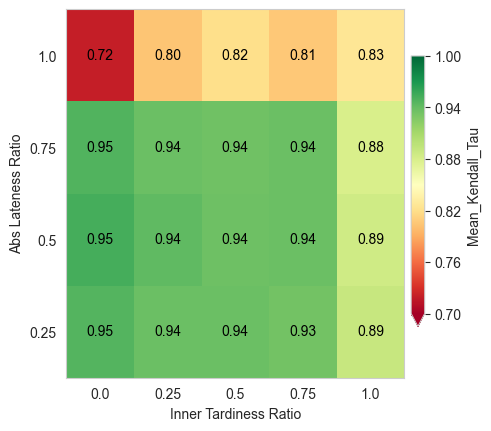

In [20]:
# 1) Kendall Tau (hoch = gut)
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    vmin=0.7,
    extend="auto"  # oder "both" | "min" | "max" | None
)

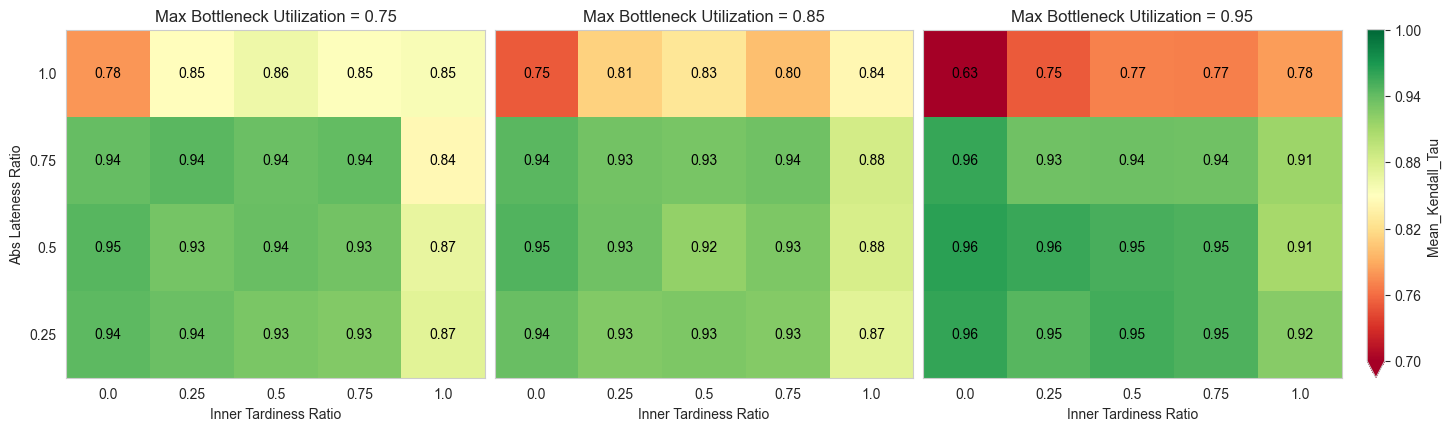

In [24]:
# 1) Kendall Tau (hoch = gut)
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    vmin=0.7, fmt=".2f",
    extend="auto"  # oder "both" | "min" | "max" | None
)


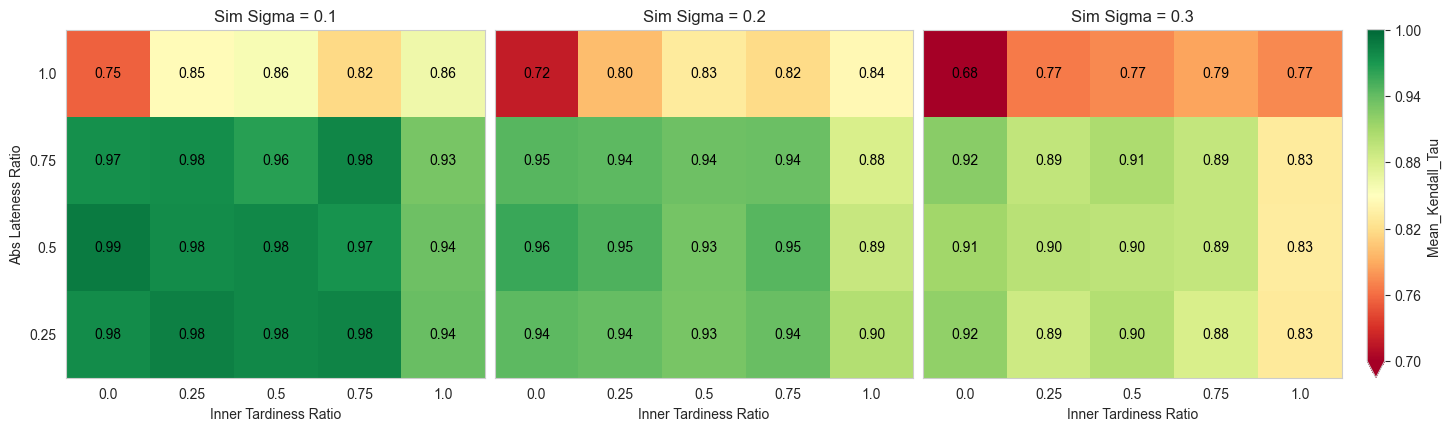

In [25]:
# 1) Kendall Tau (hoch = gut)
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Sim Sigma",
    vmin=0.7, fmt=".2f",
    extend="auto"  # oder "both" | "min" | "max" | None
)

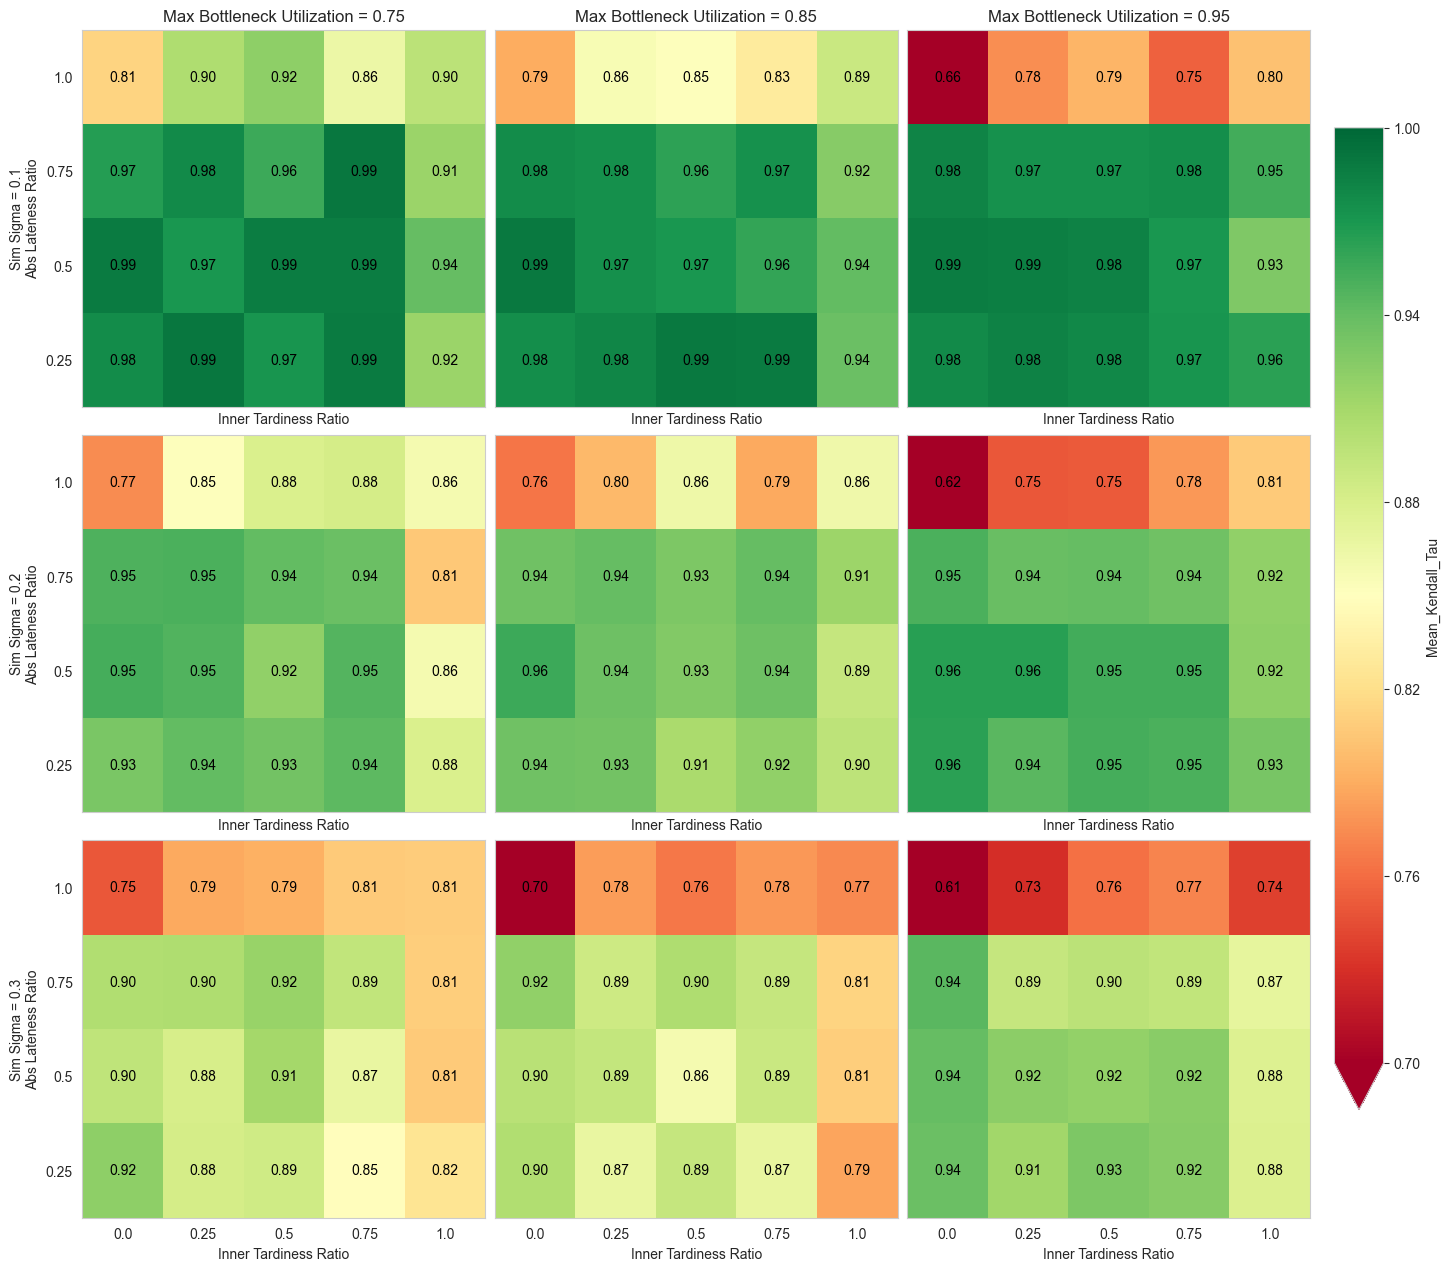

In [23]:
# 1) Kendall Tau (hoch = gut)
fig, axes = plot_experiment_heatmaps_kendall_tau(
    df_experiments,
    value_col="Mean_Kendall_Tau",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    row_col="Sim Sigma",
    vmin=0.7, fmt=".2f",
    extend="auto"  # oder "both" | "min" | "max" | None
)

fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)

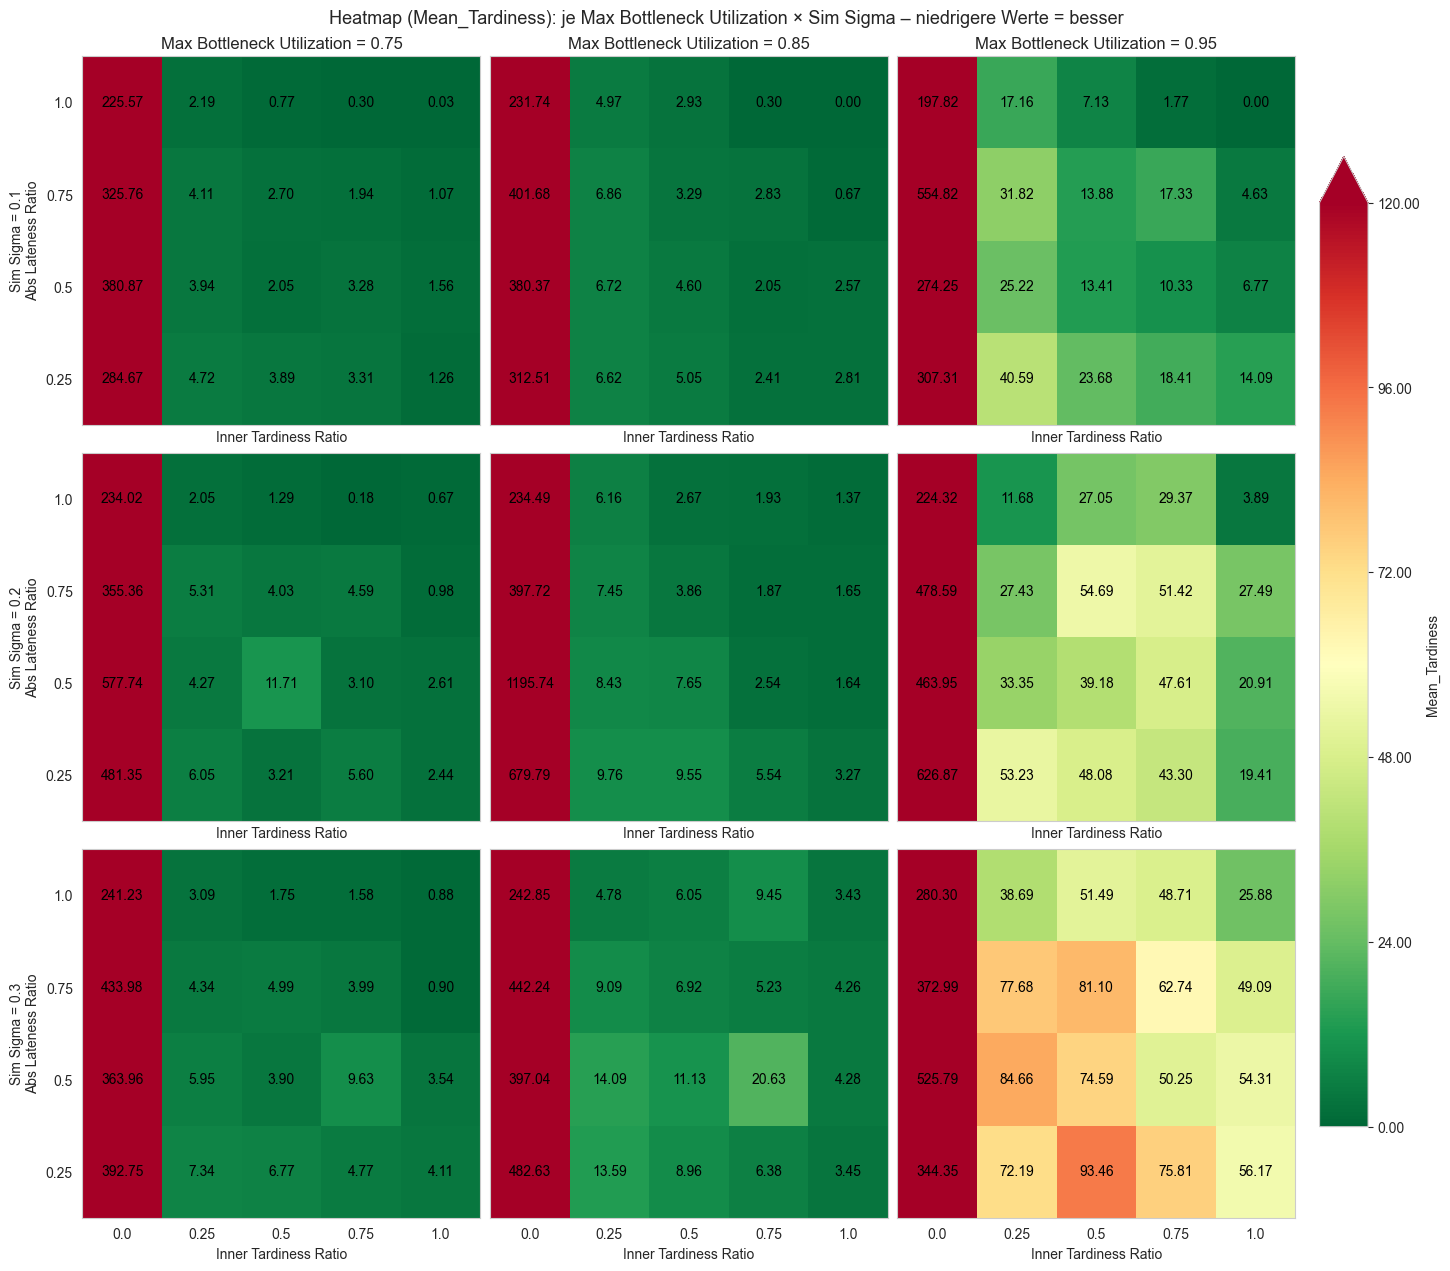

In [11]:
fig.savefig("Heatmap_Mean_Kendall_Tau.png", dpi=300)
# 2) Tardiness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Mean_Tardiness",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    row_col="Sim Sigma",
    vmin=0.0, vmax=120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

fig.savefig("Heatmap_Tardiness.png", dpi=300)

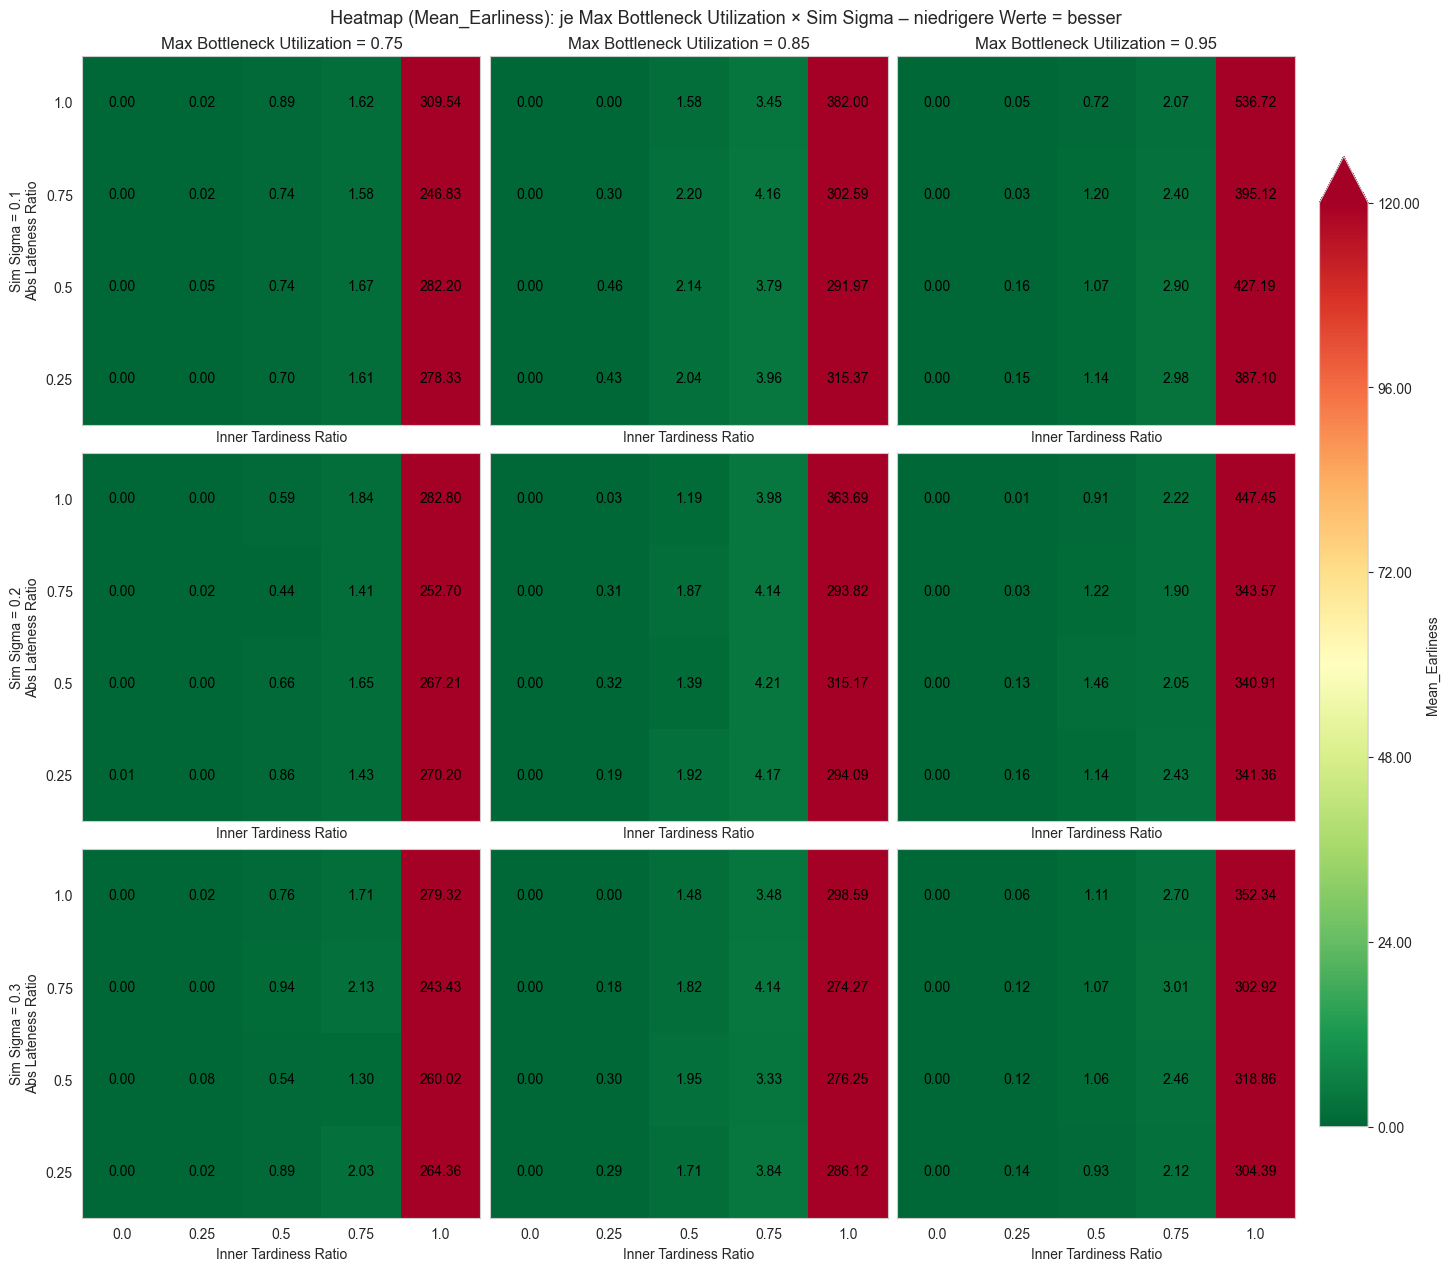

In [12]:
# 2) Earliness (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Mean_Earliness",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    row_col="Sim Sigma",
    vmin=0.0, vmax= 120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

fig.savefig("Heatmap_Earliness.png", dpi=300)

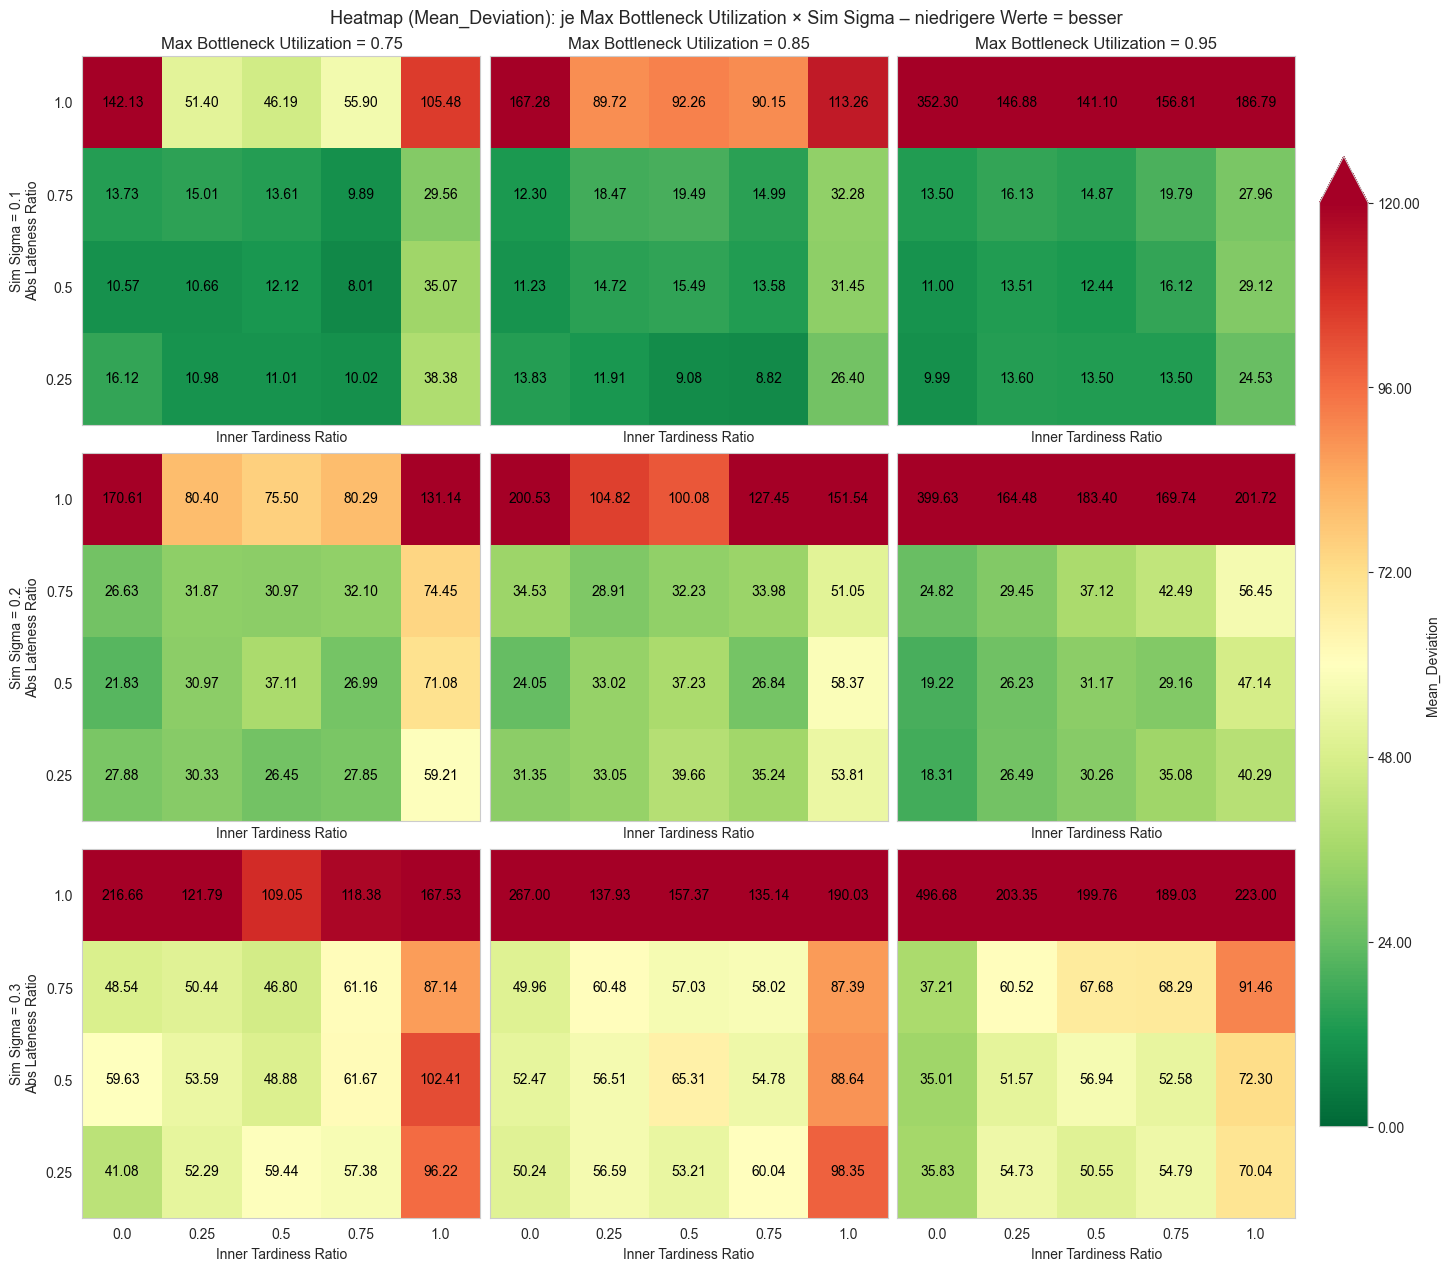

In [13]:
# 3) Deviation (niedrig = gut)
fig, axes = plot_experiment_heatmaps_good_low(
    df_experiments,
    value_col="Mean_Deviation",
    x_col="Inner Tardiness Ratio",
    y_col="Abs Lateness Ratio",
    col_col="Max Bottleneck Utilization",
    row_col="Sim Sigma",
    vmin=0.0, vmax= 120,
    #vmax=df_experiments["Mean_Tardiness"].max(),
    annot=True, fmt=".2f",
    extend="auto"
)

fig.savefig("Heatmap_Deviation.png", dpi=300)